## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def cameraCalibration(display_images=False):
    '''Add description'''
    # NOTE: The chessboard pattern used is not the standard chessboard of 8x8 squares 
    #       which have 7x7 internal corners(number black squares touching each other)
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    # 3d points in real world space
    # NOTE: (X,Y,Z) and points in Z-axis is all zeros
    objpoints = []

    # Explanation: For X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... 
    # which denotes the location of points. In this case, the results we get will 
    # be in the scale of size of chess board square. But if we know the square size, 
    # (say 30 mm), and we can pass the values as (0,0),(30,0),(60,0),..., 
    # we get the results in mm

    # 2d points in image plane.
    imgpoints = [] 

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        # NOTE: Using mpimg for reading the image, so it is read
        #       in RGB format
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners on the grayscale image
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            if display_images==True:
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                figure = plt.figure()
                plt.imshow(img)
                plt.show()
    
    # Return the object points and the image points
    return objpoints, imgpoints


## Undistort Image test

In [2]:
import os
import pickle

def undistortImage(img, objpoints, imgpoints, display_images=False):
    '''Add comments'''    
    # If the pickle exists load the camera matrix(focal points and camera center)
    # and also load the distortion coefficients to undistort the image
    try:
        dist_pickle = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]        
    except (OSError, IOError) as e:
        # NOTE: img.shape[0] is the width(columns) and img.shape[1] is the height(rows), 
        #       img.shape[2] is the number of channels(should be ignored)
        img_size = (img.shape[1], img.shape[0])

        # Do camera calibration given object points and image points
        # NOTE: mtx - Camera matrix
        #       dist - Distorting coeeficients
        #       rvecs - Rotation Vectors for each pattern view
        #       tvecs - Translation Vectors for each pattern view
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump(dist_pickle, open("camera_cal/wide_dist_pickle.p", "wb"))
        
        print("Saving calibration matrix and distortion coefficients")
    
    # Undistort the image using the camera matrix obtained from calibration
    # NOTE: The last parameter is the same as 2nd because the new camera matrix 
    #       should be the same as the source 
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)

    if display_images == True:
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image(S1)', fontsize=30)
        ax2.imshow(undistorted_image)
        ax2.set_title('Undistorted Image', fontsize=30)
    
    return undistorted_image

# Apply color and gradient transform

In [3]:
def colorAndGradientThreshold(img, sx_thresh=(20, 120), s_thresh=(120, 220), 
                              kernel_size=9, display_images=False):
    '''Add comments'''
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Take the derivative in x
    sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=kernel_size)
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel_x = np.absolute(sobel_x)
    # 8 bit scaling
    scaled_sobel_x = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))

    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # NOTE 1: This returns a stack of the two binary images, whose components
    #         you can see as different colors
    # NOTE 2: color_binary[:, :, 0] is all 0s, effectively an all black image.
    #         It might be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary))

    # Combined binary output with color and gradient thresholding
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[((sx_binary==1) | (s_binary==1))] = 1

    if display_images == True:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(img)
        ax1.set_title('Original Image(S2)', fontsize=40)

        ax2.imshow(combined_binary, cmap="gray")
        ax2.set_title('Color&Gradient Image', fontsize=40)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return combined_binary

## Perspective Transform

In [4]:
def areaInFocus(img, vertices, display_images=False):
    # Convert the 2D Gray image into 3D image with all 1's set to 255
    image_in_focus = np.dstack((img, img, img))*255
    
    # Filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.polylines(image_in_focus, [vertices], True, (255, 0, 0), 3, 4)
    
    #imageInFocus[(imageInFocus >= 255)] = 1
    
    if display_images == True:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        
        ax1.imshow(img, cmap="gray")
        ax1.set_title('Original Image(S3)', fontsize=40)

        ax2.imshow(image_in_focus, cmap="gray")
        ax2.set_title('Area in focus', fontsize=40)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return

def perspectiveTransform(img, display_images=False):
    # Get the image shape
    imshape = img.shape

    # Define vertices for a polygon for the area in focus(Trapezoid)
    vy1 = np.int32(imshape[0] * 0.625)
    vx1 = 620
    vy2 = vy1
    vx2 = 720

    # Source vertices
    src_vertices = np.array([[(80, imshape[0]),
                              (vx1, vy1),
                              (vx2, vy2),
                              (imshape[1]-80, imshape[0])]])

    # Display area in focus(Optional)
    areaInFocus(img, src_vertices)
    
    # Destination vertices to get perspectice
    dst_vertices = np.array([[(80, imshape[0]),
                              (80, 0),
                              (imshape[1]-80, 0),
                              (imshape[1]-80, imshape[0])]])
    
    # Convert the indices into float
    src_vertices = np.float32(src_vertices)
    dst_vertices = np.float32(dst_vertices)
    
    # Apply the perspective transform and get the matrix
    matrix = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    
    # Apply inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst_vertices, src_vertices)
    
    # Warped image
    # NOTE: Pass in width and height(size of the image)
    warped_image = cv2.warpPerspective(img, matrix, (imshape[1], imshape[0])) 
    
    if display_images == True:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        
        ax1.imshow(img, cmap="gray")
        ax1.set_title('Original Image(S4)', fontsize=40)

        ax2.imshow(warped_image, cmap="gray")
        ax2.set_title('Warped Image', fontsize=40)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped_image, Minv

## Sliding Window and Fit a Polynomial

In [5]:
def slidingWindow(img, display_images=False):
    '''Add comments'''
    try:
        # Load the pickle file if it exists
        line_fit_pickle = pickle.load(open("line_fit_coefficients.p", "rb"))
        
        left_fit = np.array([0.0, 0.0, 0.0])
        right_fit = np.array([0.0, 0.0, 0.0])
        
        # Save the line fit of the left lines
        left_fit[0] = line_fit_pickle["lA"]
        left_fit[1] = line_fit_pickle["lB"]
        left_fit[2] = line_fit_pickle["lC"]

        # Save the line fit of the right lines
        right_fit[0] = line_fit_pickle["rA"]
        right_fit[1] = line_fit_pickle["rB"]
        right_fit[2] = line_fit_pickle["rC"]
        
        # Get the non-zero values of the image
        nonzero = img.nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        
        # Width of the window
        margin = 100
        
        # Find the left and right lane indices within a margin specified
        left_lane_indices = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - margin)) & 
                             (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin))) 
        right_lane_indices = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - margin)) & 
                              (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))  
        
        # Again, extract left and right line pixel positions
        left_x = nonzero_x[left_lane_indices]
        left_y = nonzero_y[left_lane_indices] 
        right_x = nonzero_x[right_lane_indices]
        right_y = nonzero_y[right_lane_indices]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)
        
        # Generate x and y values for plotting
        plot_y = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
        right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
        
        # Save the line fit of the left lines
        line_fit_pickle["lA"] = left_fit[0]
        line_fit_pickle["lB"] = left_fit[1]
        line_fit_pickle["lC"] = left_fit[2]

        # Save the line fit of the right lines
        line_fit_pickle["rA"] = right_fit[0]
        line_fit_pickle["rB"] = right_fit[1]
        line_fit_pickle["rC"] = right_fit[2]

        pickle.dump(line_fit_pickle, open("line_fit_coefficients.p", "wb"))
        
        # Create an image to draw on and an image to show the selection window
        output_image = np.dstack((img, img, img))*255
        window_image = np.zeros_like(output_image)
        
        # Color in left and right line pixels
        output_image[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
        output_image[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fit_x-margin, plot_y]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_x+margin, plot_y])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_fit_x-margin, plot_y]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fit_x+margin, plot_y])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_image, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_image, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(output_image, 1, window_image, 0.3, 0)
        plt.imshow(result)
        
        # Plot the lines
        plt.plot(left_fit_x, plot_y, color='yellow')
        plt.plot(right_fit_x, plot_y, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        return plot_y, left_fit_x, right_fit_x
    except(OSError, IOError) as e:
        # Assuming you have created a warped binary image called "img"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[img.shape[0]/4:,:], axis=0)
        if display_images == True:
            figure=plt.figure()
            plt.plot(histogram)
            plt.title("Histogram of intensities")

        # Create an output image to draw on and  visualize the result
        output_image = np.dstack((img, img, img))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        left_base_x = np.argmax(histogram[:midpoint])
        right_base_x = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        number_windows = 8

        # Set height of windows
        window_height = np.int(img.shape[0]/number_windows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        # Rows
        nonzero_y = np.array(nonzero[0])
        # Columns
        nonzero_x = np.array(nonzero[1])

        # Current positions to be updated for each window
        left_current_x = left_base_x
        right_current_x = right_base_x

        # Set the width of the windows +/- margin
        margin = 100

        # Set minimum number of pixels found to recenter window
        minimum_pixels = 50

        # Create empty lists to receive left and right lane pixel indices
        left_lane_indices = []
        right_lane_indices = []

        # Step through the windows one by one
        for window in range(number_windows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_left_low_x = left_current_x - margin
            win_left_high_x = left_current_x + margin
            win_right_low_x = right_current_x - margin
            win_right_high_x = right_current_x + margin

            # Draw the windows on the visualization image
            cv2.rectangle(output_image,(win_left_low_x,win_y_low),(win_left_high_x,win_y_high),(0,255,0), 2)
            cv2.rectangle(output_image,(win_right_low_x,win_y_low),(win_right_high_x,win_y_high),(0,255,0), 2)

            # Identify the nonzero pixels in x and y within the window
            good_left_indices = ((nonzero_y >= win_y_low) & 
                                 (nonzero_y < win_y_high) & 
                                 (nonzero_x >= win_left_low_x) & 
                                 (nonzero_x < win_left_high_x)).nonzero()[0]

            good_right_indices = ((nonzero_y >= win_y_low) & 
                                  (nonzero_y < win_y_high) & 
                                  (nonzero_x >= win_right_low_x) & 
                                  (nonzero_x < win_right_high_x)).nonzero()[0]

            # Append these indices to the lists
            left_lane_indices.append(good_left_indices)
            right_lane_indices.append(good_right_indices)

            # If there were more than 50 pixels found in the window, recenter the window
            # for the next iteration. So if pixels are leaning left then recenter the window
            # for the next iteration to the left or vice versa
            if len(good_left_indices) > minimum_pixels:
                left_current_x = np.int(np.mean(nonzero_x[good_left_indices]))
            if len(good_right_indices) > minimum_pixels:
                right_current_x = np.int(np.mean(nonzero_x[good_right_indices]))

        if display_images == True:
            # Plot the result
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()

            ax1.imshow(img, cmap="gray")
            ax1.set_title('Original Image(S5)', fontsize=40)

            ax2.imshow(output_image)
            ax2.set_title('Sliding Window Image', fontsize=40)

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

        # Concatenate the arrays of indices
        left_lane_indices = np.concatenate(left_lane_indices)
        right_lane_indices = np.concatenate(right_lane_indices)

        # Extract left and right line pixel positions
        left_x = nonzero_x[left_lane_indices]
        left_y = nonzero_y[left_lane_indices]
        right_x = nonzero_x[right_lane_indices]
        right_y = nonzero_y[right_lane_indices]

        # Fit a second order polynomial for each of the lines
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)

        # Generate x and y values for plotting
        plot_y = np.linspace(0, img.shape[0]-1, img.shape[0])

        # f(y) = Ay**2 + By + C
        left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
        right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]

        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
        line_fit_pickle = {}
        
        # Save the line fit of the left lines
        line_fit_pickle["lA"] = left_fit[0]
        line_fit_pickle["lB"] = left_fit[1]
        line_fit_pickle["lC"] = left_fit[2]

        # Save the line fit of the right lines
        line_fit_pickle["rA"] = right_fit[0]
        line_fit_pickle["rB"] = right_fit[1]
        line_fit_pickle["rC"] = right_fit[2]

        pickle.dump(line_fit_pickle, open("line_fit_coefficients.p", "wb"))

        print("Saving the line fit coefficients")

        # Color the pixels with the indices with red and blue
        output_image[left_y, left_x] = [255, 0, 0]
        output_image[right_y, right_x] = [0, 0, 255]
        plt.imshow(output_image)

        # Plot the x and y values based on the equation
        plt.plot(left_fit_x, plot_y, color='yellow')
        plt.plot(right_fit_x, plot_y, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
        return plot_y, left_fit_x, right_fit_x

## Draw lines

In [6]:
def drawLane(img, warped, Minv, plot_y, left_fit_x, right_fit_x):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    figure = plt.figure()
    plt.imshow(result)
    plt.title("Lane Image")

/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:95: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Saving the line fit coefficients


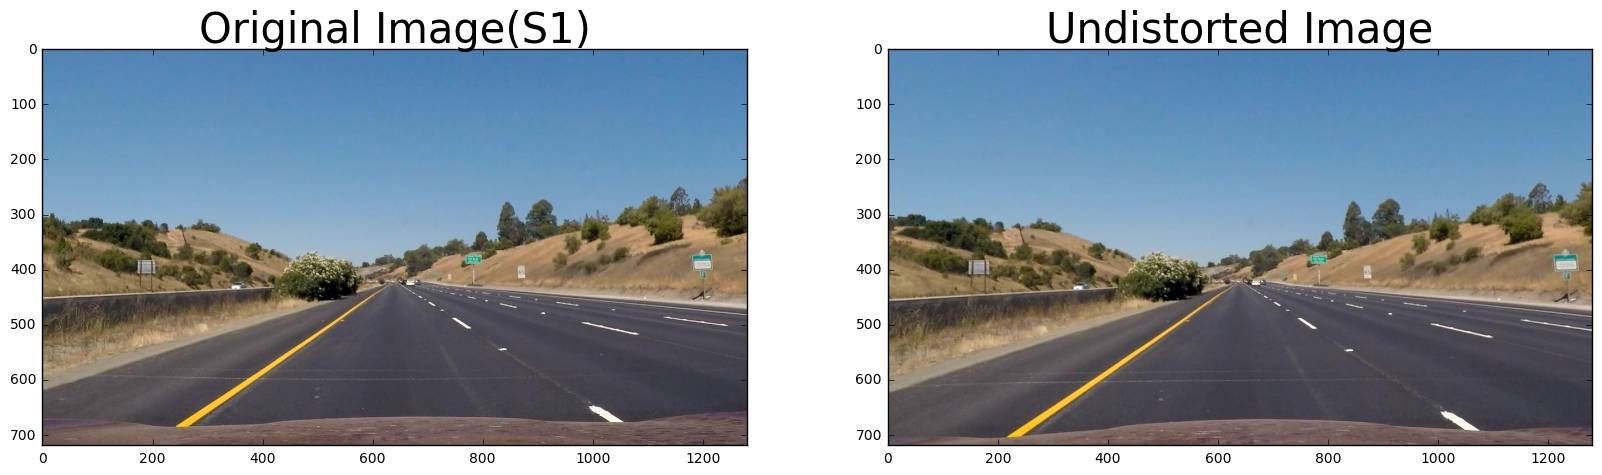

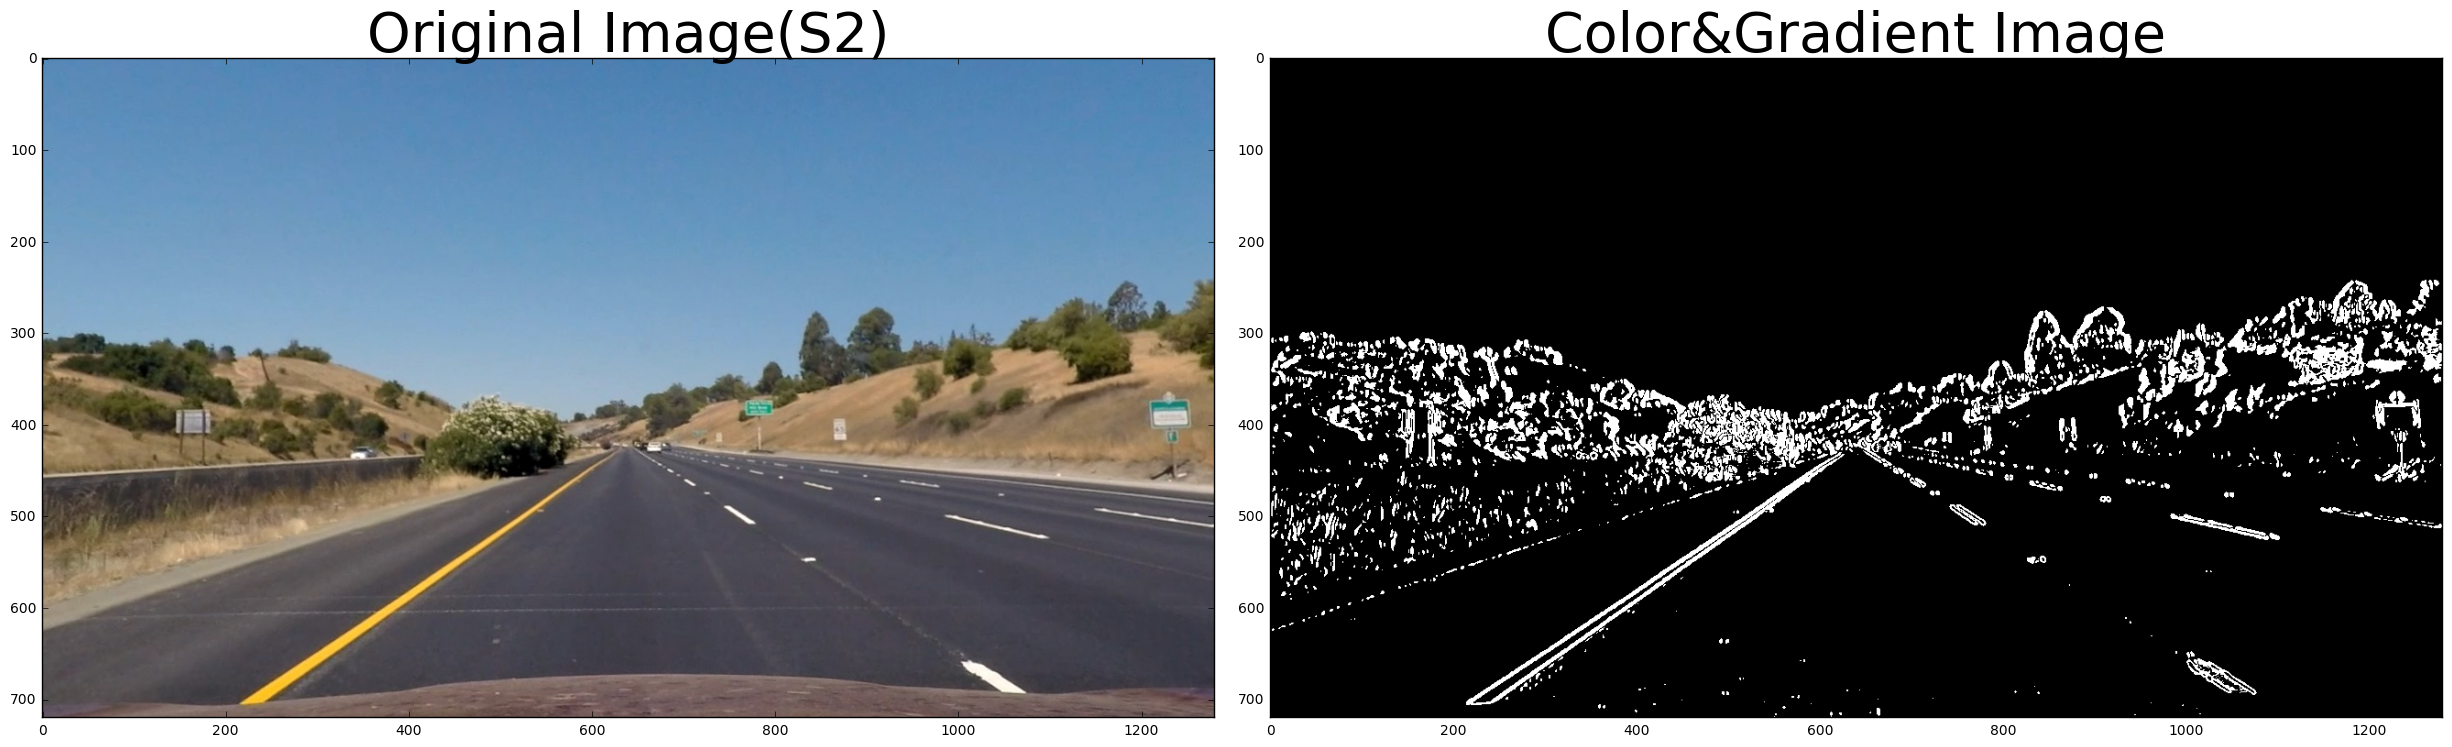

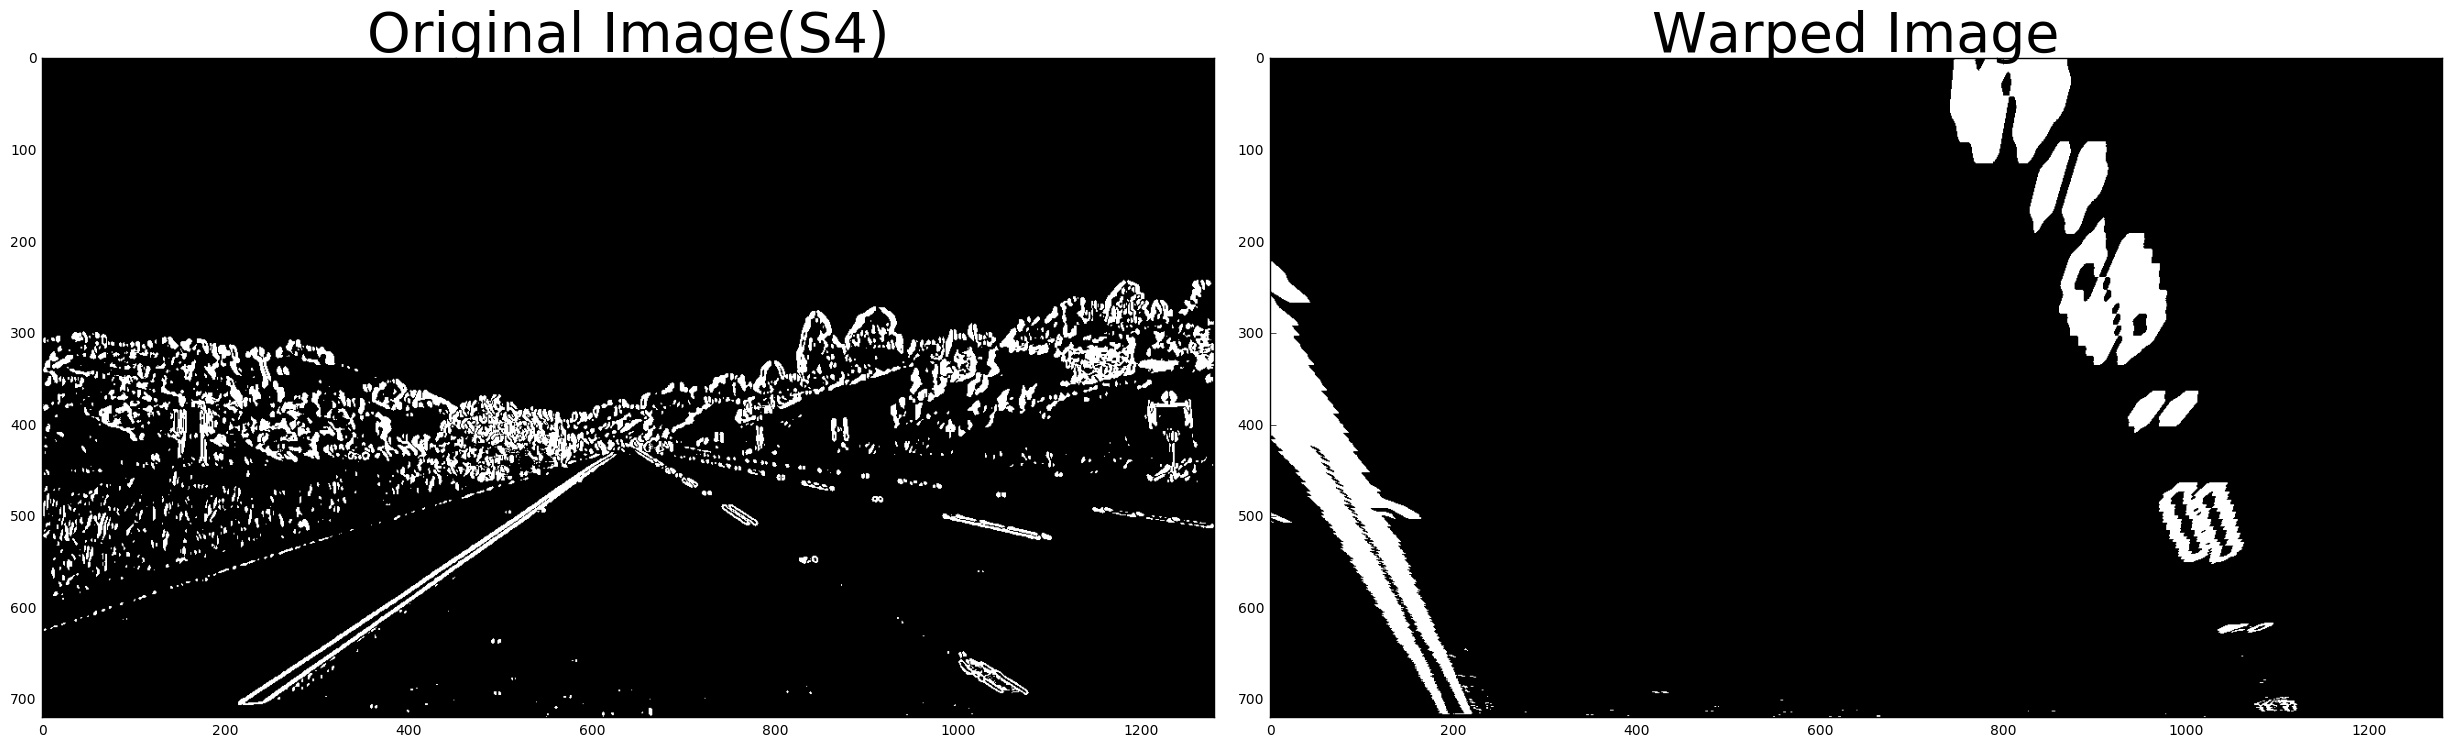

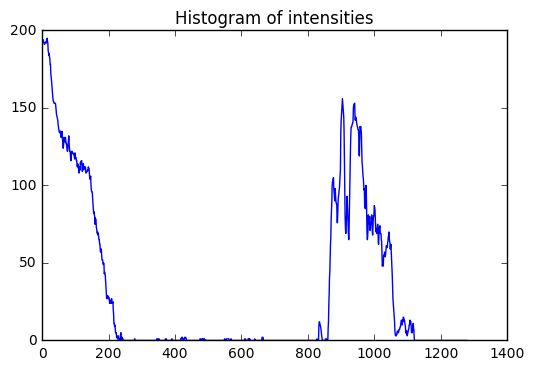

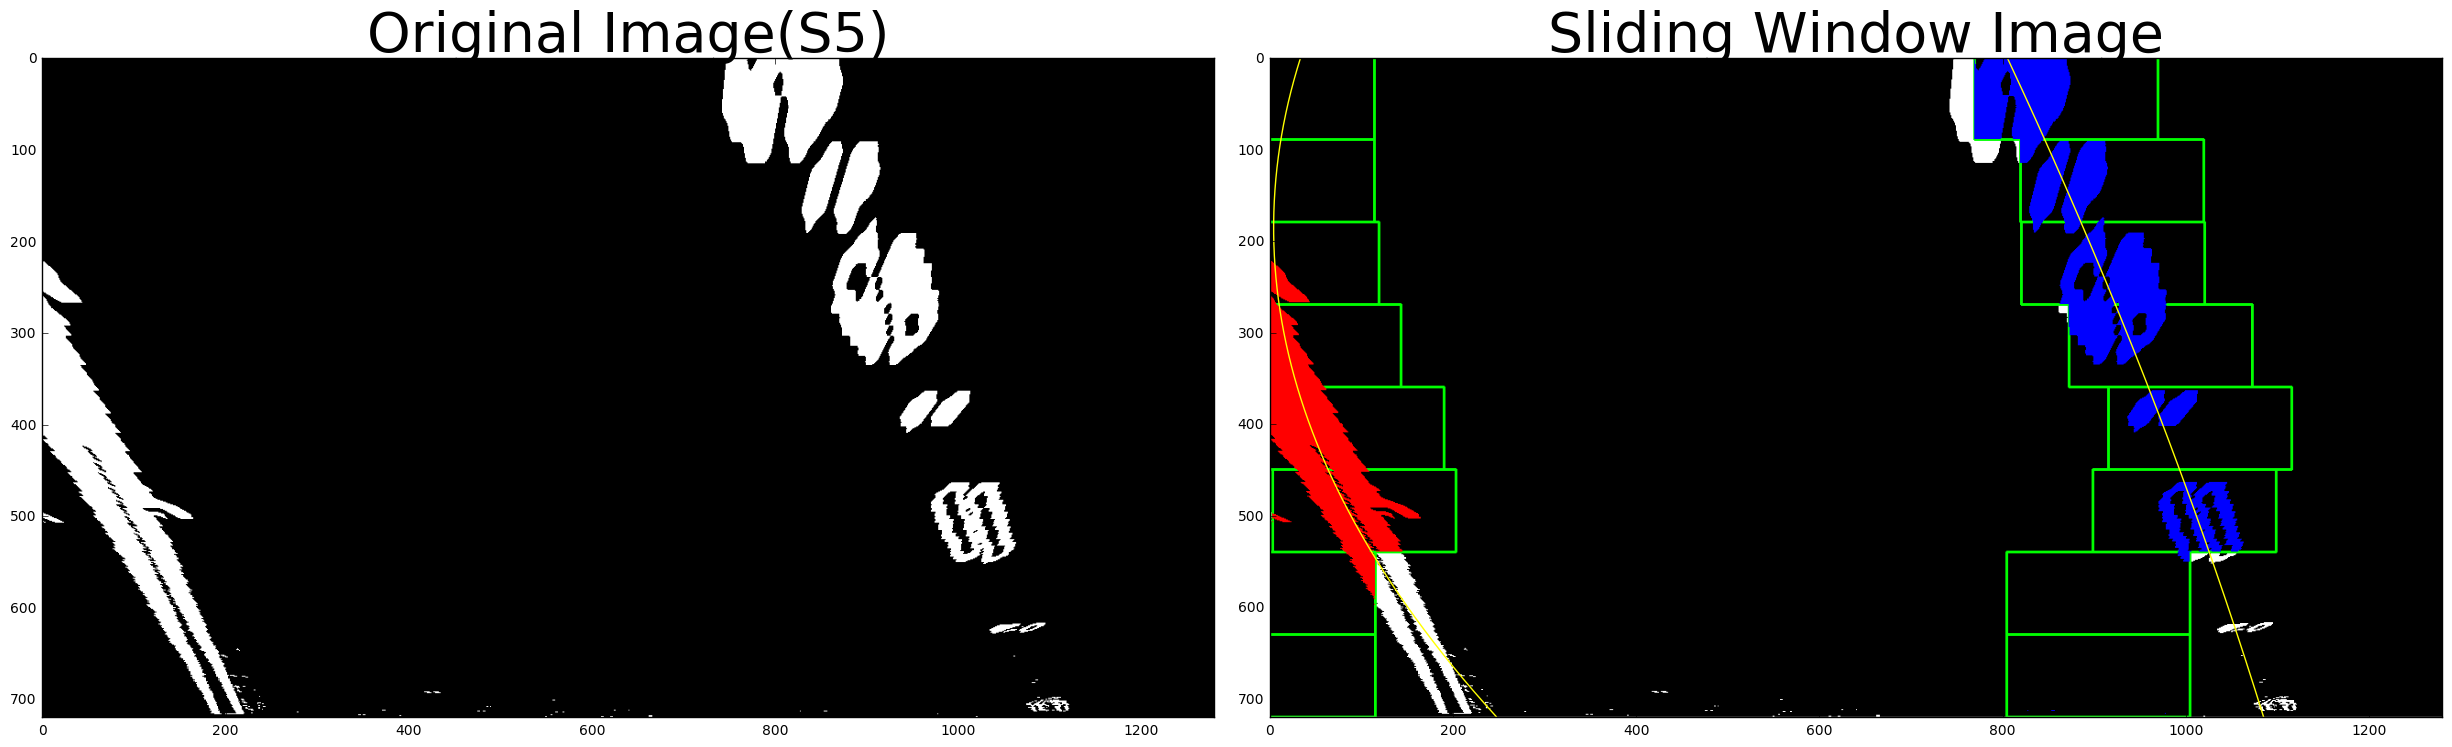

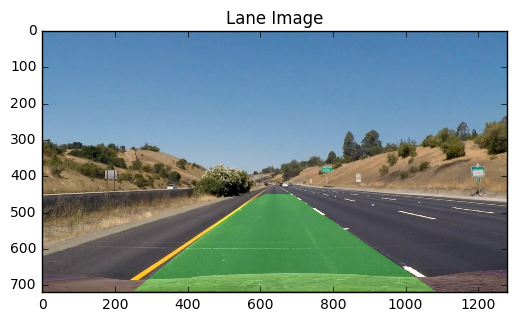

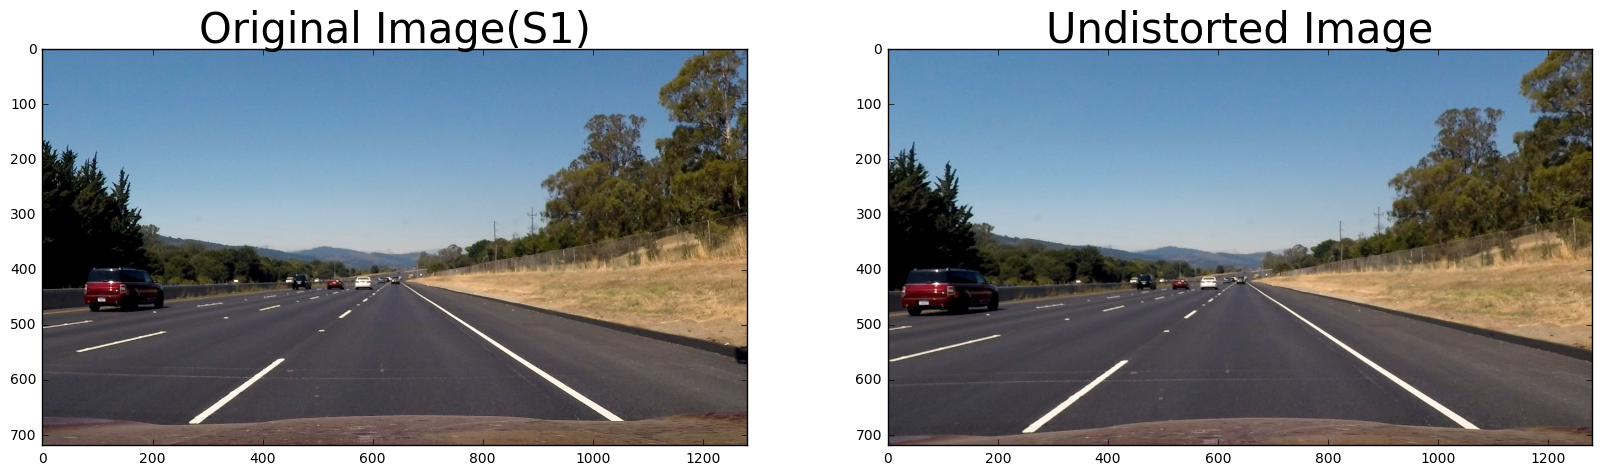

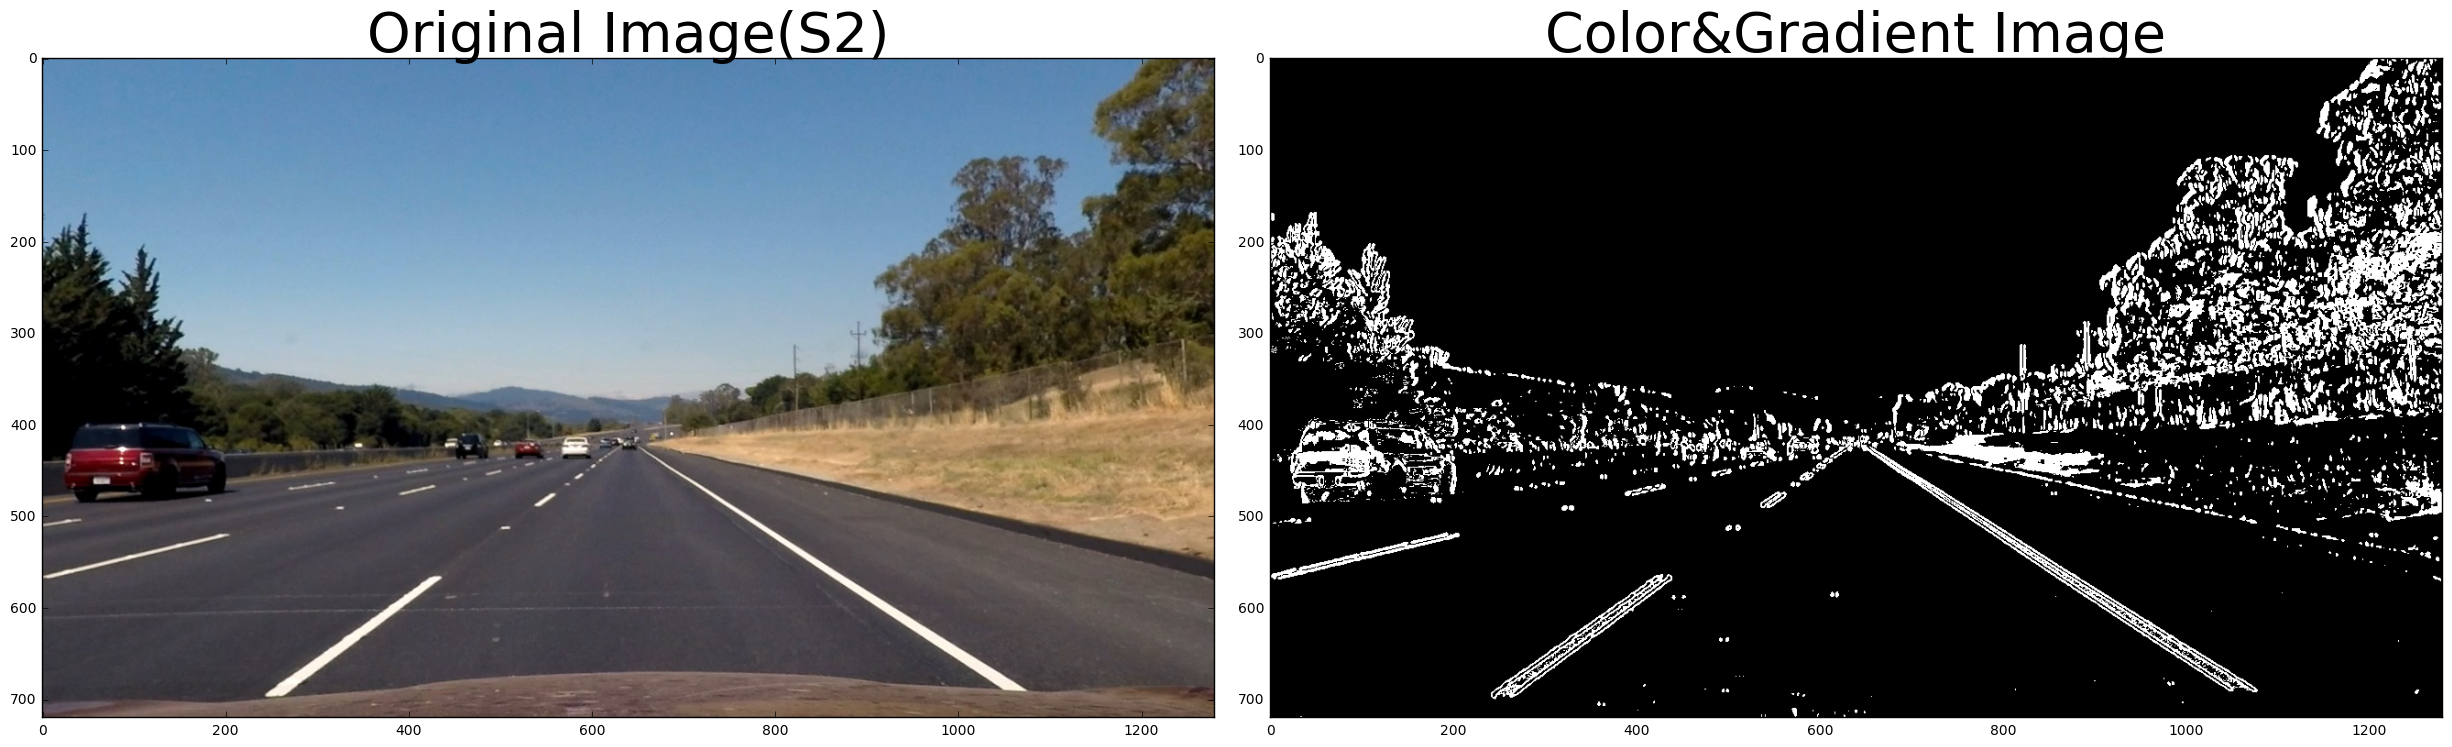

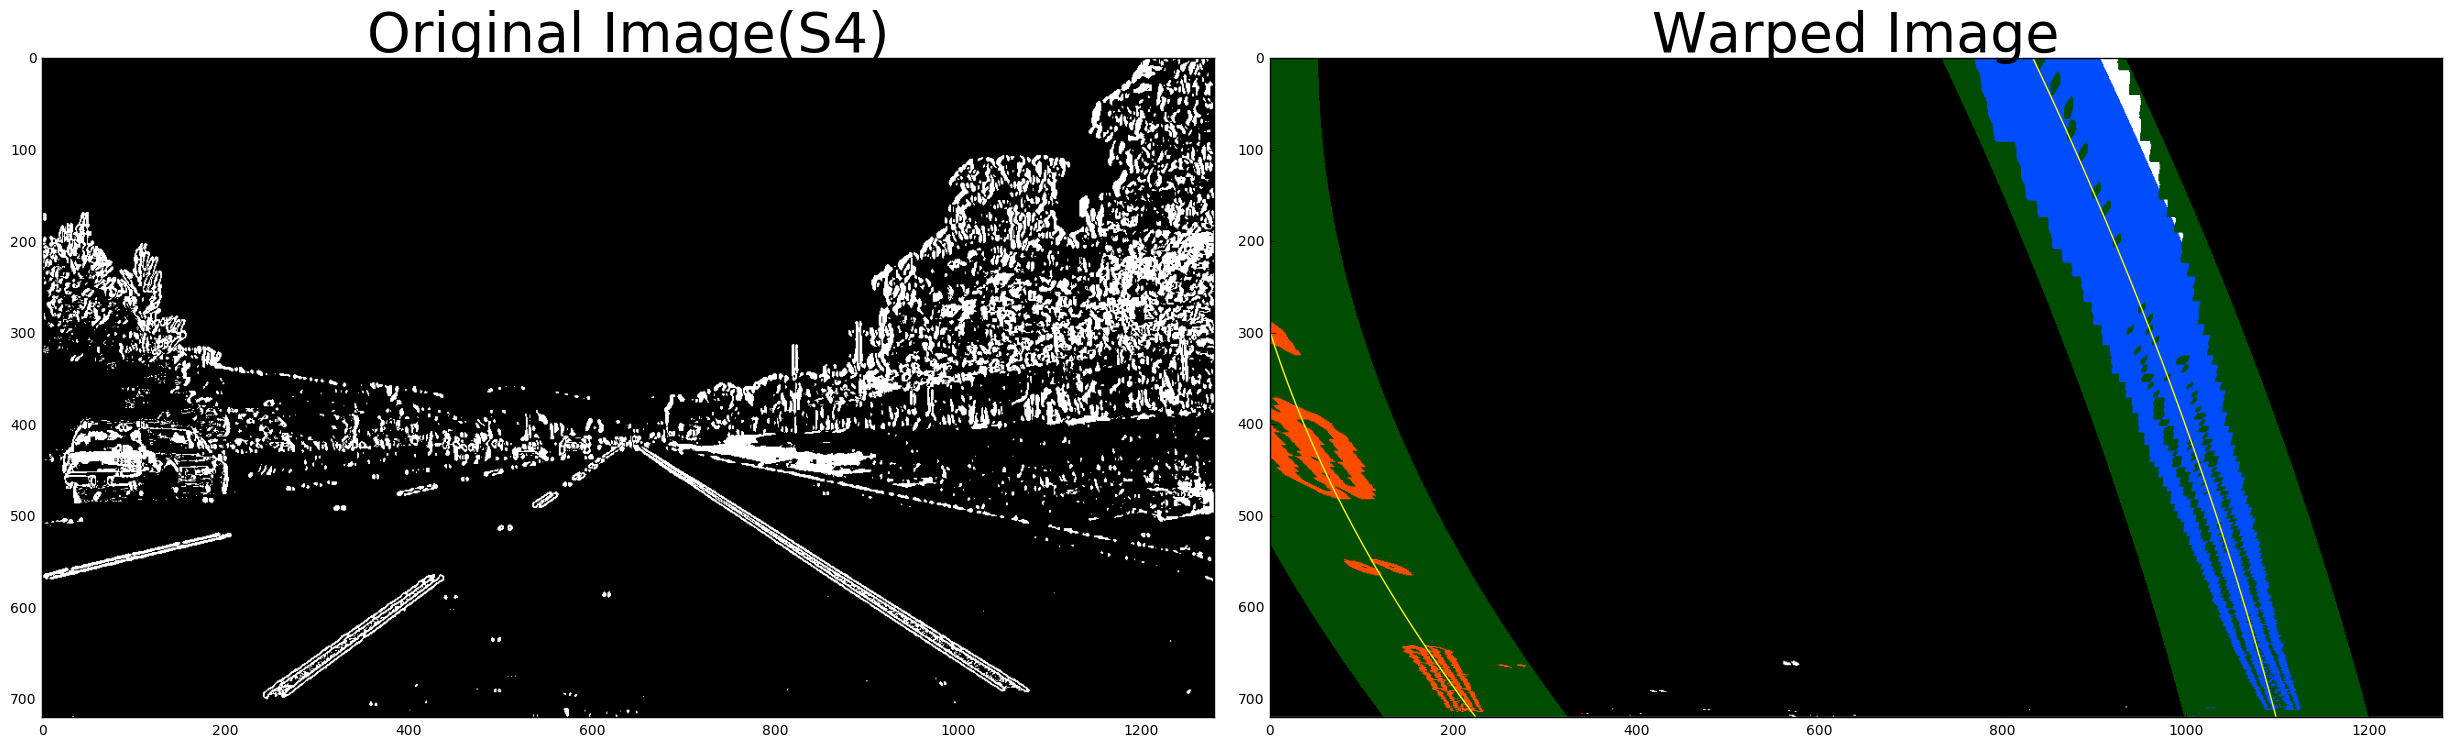

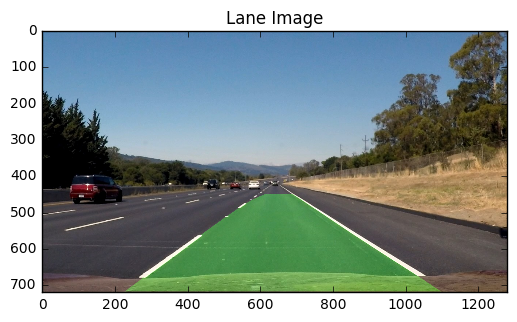

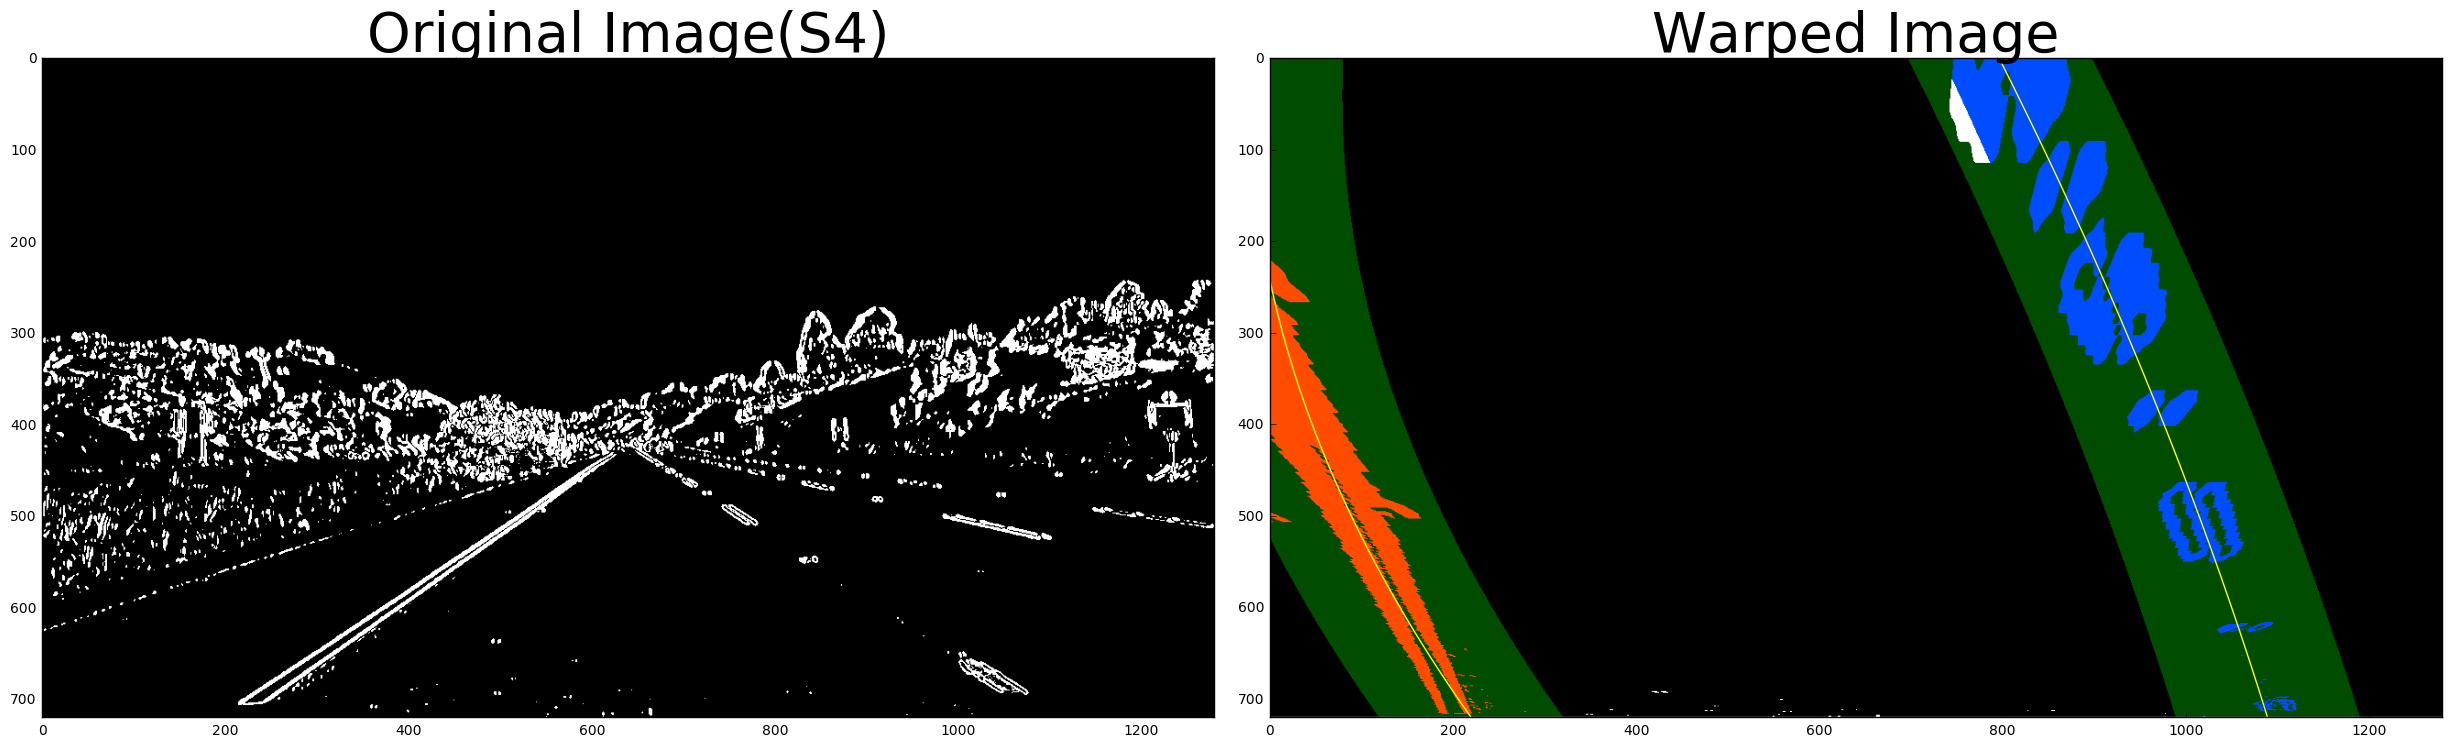

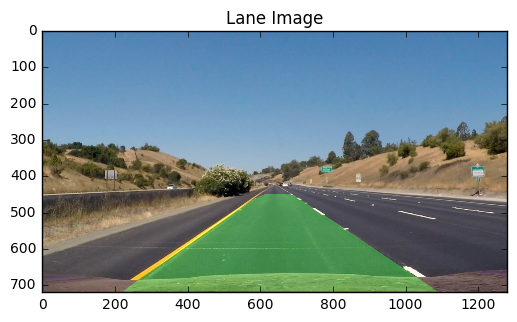

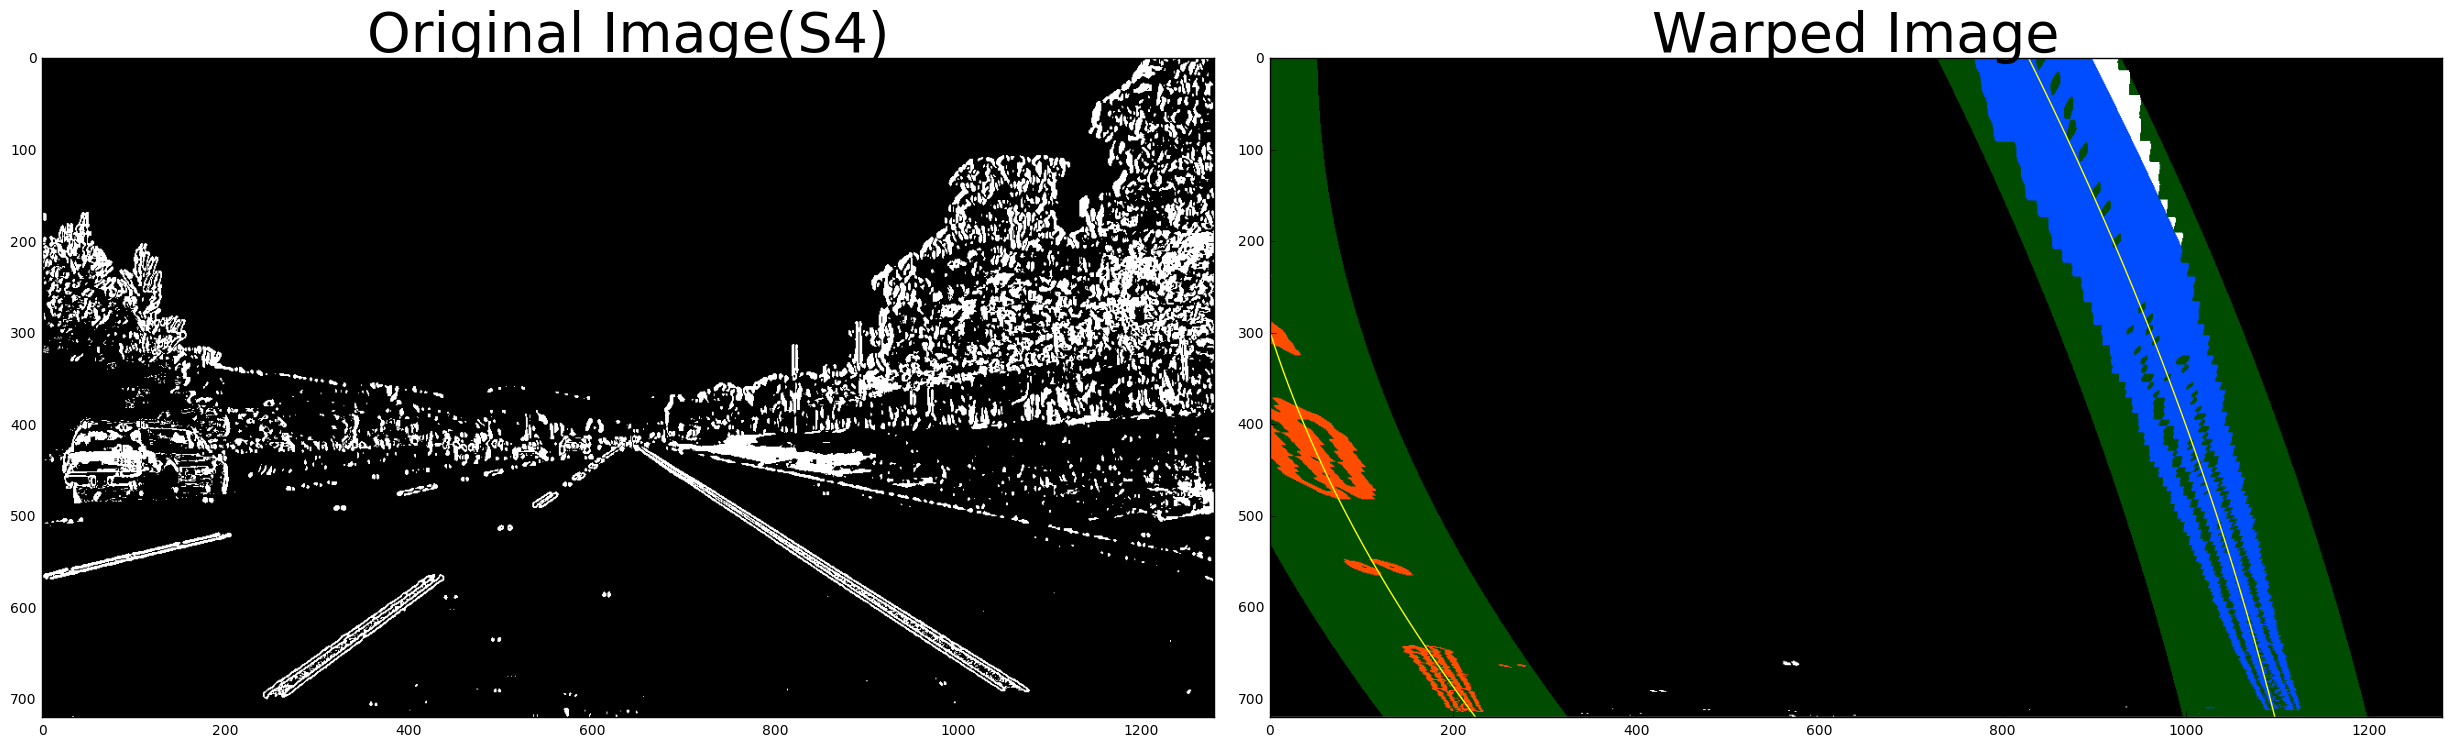

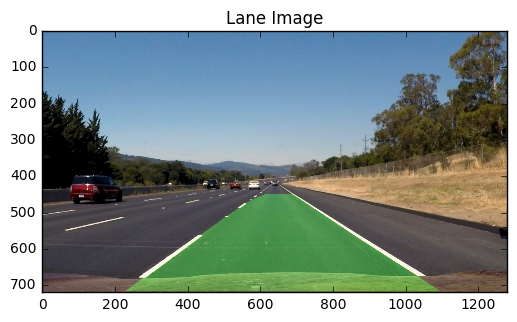

In [7]:
# Calibrate the camera one time only
objpoints, imgpoints = cameraCalibration()

# Undistort the image(needs to go in the pipeline)
        
# Make a list of calibration images
test_images = glob.glob('test_images/straight_lines*.jpg')

# Set 1
for idx, fname in enumerate(test_images):
    if(idx == 0) or True:
        # Get the image to test
        test_image = mpimg.imread(fname)
        
        # Undistort the image
        undistorted_image = undistortImage(test_image, objpoints, imgpoints, True)
        
        # Apply color and gradient thresholding
        thresholded_image = colorAndGradientThreshold(img=undistorted_image, display_images=True)
        
        # Get the perspective transform of the image
        warped_image, Minv = perspectiveTransform(thresholded_image, True)
        warped = np.copy(warped_image)
        
        # Apply sliding window
        plot_y, left_fit_x, right_fit_x = slidingWindow(warped, True)
        
        # Draw the lane
        drawLane(test_image, warped_image, Minv, plot_y, left_fit_x, right_fit_x)
        
# Set 2
test_images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(test_images):
    if(idx == 0) or True:
        # Get the image to test
        test_image = mpimg.imread(fname)
        
        # Undistort the image
        undistorted_image = undistortImage(test_image, objpoints, imgpoints)
        
        # Apply color and gradient thresholding
        thresholded_image = colorAndGradientThreshold(img=undistorted_image)
        
        # Get the perspective transform of the image
        warped_image, Minv = perspectiveTransform(thresholded_image, True)
        warped = np.copy(warped_image)
        
        # Apply sliding window
        plot_y, left_fit_x, right_fit_x = slidingWindow(warped, False)
        
        # Draw the lane
        drawLane(test_image, warped_image, Minv, plot_y, left_fit_x, right_fit_x)